In [2]:
from collections import Counter, defaultdict
import sys
from typing import Tuple


import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from seqeval import metrics
import torch
import transformers as tfm

sys.path.append("../src")

import ner

%load_ext autoreload
%autoreload 2


/Users/spayot/miniforge3/envs/tfm4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pd.set_option('display.max_colwidth', None)

MODEL_CKPT = "xlm-roberta-base"

# MultiLingual NER
* Using XLM-R model
* task: create NER model for swiss languages (de, fr, it, en)
* dataset: XTREME - PAN-X: de, fr, it, en

## Dataset
### Load

In [4]:
langs = {"de": 0.629, "fr": 0.229, "it": 0.084, "en": 0.059}

# return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(datasets.DatasetDict)

for lang, frac in langs.items():
    # load monolingual corpus
    ds = datasets.load_dataset("xtreme", name=f"PAN-X.{lang}")
    # sample examples to create imbalanced dataset based on language prevalence
    for split in ds:
        panx_ch[lang][split] = (ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))

    

Found cached dataset xtreme (/Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)
100%|██████████| 3/3 [00:00<00:00, 130.11it/s]
Loading cached shuffled indices for dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-e5ddf09f1ae095ec.arrow
Loading cached shuffled indices for dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-25e7e2dd003d0fa6.arrow
Loading cached shuffled indices for dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-73a95bc0accfea8b.arrow
Found cached dataset xtreme (/Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)
100%|██████████| 3/3

### Exploratory Data Analysis

In [5]:
# inspecting the number of examples for each language
for lang, ds in panx_ch.items():
    print(lang, ds["train"].num_rows, "rows", sep=" ")

de 12580 rows
fr 4580 rows
it 1680 rows
en 1180 rows


In [6]:
# what are the features in each dataset?
panx_ch["de"]["train"].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None),
 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [7]:
# let's add string tags 
tags = panx_ch["de"]["train"].features["ner_tags"].feature

def create_tag_names(batch: dict):
    # tags.int2str turns a list of ids into str labels
    tag_names: list = [tags.int2str(tag_id) for tag_id in batch["ner_tags"]] 
    
    return {"ner_tags_str": tag_names}

batch = ds["train"][:3]

print(create_tag_names(batch))

    

{'ner_tags_str': [['O', 'O', 'B-ORG', 'I-ORG', 'O', 'O'], ['B-ORG', 'I-ORG', 'O', 'B-PER', 'I-PER'], ['B-LOC', 'I-LOC', 'I-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O']]}


In [8]:
panx_de = panx_ch["de"].map(create_tag_names)

de_example = panx_de["train"][0]

pd.DataFrame(de_example)[["tokens", "ner_tags_str"]].T



Loading cached processed dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-193a8d7ac1077590.arrow
Loading cached processed dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-f299581438c55b9a.arrow
Loading cached processed dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-3f248af3e70ec86f.arrow


,0,1,2,3,4,5,6,7,8,9,10,11
tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
ner_tags_str,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


#### How many of each tags in DE dataset?

In [9]:
freqs = defaultdict(Counter)

for split, ds in panx_de.items():
    for tag_list in ds["ner_tags_str"]:
        for tag in tag_list:
            if tag.startswith("B-"):
                freqs[split][tag[2:]] += 1

pd.DataFrame(freqs)

,train,validation,test
LOC,6186,3172,3180
ORG,5366,2683,2573
PER,5810,2893,3071


## Tokenizer

In [10]:
xlmr_tokenizer = tfm.AutoTokenizer.from_pretrained(MODEL_CKPT)

text = "This can probably be done. N'est-ce pas?"

print(xlmr_tokenizer(text).tokens())

['<s>', '▁This', '▁can', '▁probably', '▁be', '▁done', '.', '▁N', "'", 'est', '-', 'ce', '▁pas', '?', '</s>']


## Model instantiation

In [11]:
id2label = dict(enumerate(tags.names))
label2id = {tag: idx for idx, tag in enumerate(tags.names)}

xlmr_config = tfm.AutoConfig.from_pretrained(MODEL_CKPT, num_labels=tags.num_classes, 
                                         id2label=id2label, label2id=label2id)

xlmr = tfm.AutoModelForTokenClassification.from_pretrained(MODEL_CKPT, config = xlmr_config)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-st

In [12]:
# verify that the model outputs something with the expected format:
print(f"original text \"{text}\"")

tokens = xlmr_tokenizer(text).tokens()
print(f"number of tokens after tokenization: {len(xlmr_tokenizer(text).tokens())}")

input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")

outputs = xlmr(input_ids)
print(f"outputs size: {outputs.logits.size()}")

pred_ids = outputs.logits.argmax(-1).numpy()
example = {
    "tokens": tokens, 
    "ids": input_ids[0].numpy(),
    "preds": outputs.logits.argmax(-1).numpy()[0],
    }

example = pd.DataFrame(example)

example["pred_labels"] = example.preds.map(id2label)
display(example.drop("preds", axis=1).T)

original text "This can probably be done. N'est-ce pas?"
number of tokens after tokenization: 15
outputs size: torch.Size([1, 15, 7])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,<s>,▁This,▁can,▁probably,▁be,▁done,.,▁N,',est,-,ce,▁pas,?,</s>
ids,0,3293,831,31895,186,16940,5,541,25,525,9,329,452,32,2
pred_labels,B-PER,I-ORG,I-ORG,I-ORG,B-PER,I-ORG,B-PER,I-PER,B-PER,I-ORG,B-PER,B-PER,I-ORG,B-PER,B-PER


In [13]:
# refactored: turning above into a function
ner.inspect.tag_text(
    text="let's try with another text now. en francais", 
    model=xlmr,
    tokenizer=xlmr_tokenizer,
    tags=tags,
    )


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
tokens,<s>,▁let,',s,▁try,▁with,▁another,▁text,▁now,.,▁en,▁franca,is,</s>
tags,B-PER,I-ORG,B-PER,B-PER,I-ORG,B-PER,I-ORG,I-ORG,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER


## Preparing the Dataset
* tokenize doc
* add labels for unlabeled tokens (e.g. second part of split words, or initial character).

In [14]:
# refactored: moved tokenize_and_align_labels to ner.preproc module
def encode_panx_dataset(corpus: datasets.DatasetDict) -> datasets.DatasetDict:
    return corpus.map(ner.preproc.tokenize_and_align_labels,
        fn_kwargs={"tokenizer": xlmr_tokenizer}, 
        batched=True, 
        remove_columns=["langs", "ner_tags", "tokens"]
        )

panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Loading cached processed dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-c7be8333fea9e107.arrow
100%|██████████| 7/7 [00:00<00:00, 26.52ba/s]
Loading cached processed dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-a3db93457688929d.arrow


In [15]:
example = panx_de_encoded["train"][0]
df = pd.DataFrame(example)
df["tokens"] = xlmr_tokenizer.convert_ids_to_tokens(example["input_ids"])
df.T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
input_ids,0,70101,176581,19,142,122,2290,708,1505,18363,...,13787,14,15263,18917,663,6947,19,6,5,2
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
labels,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


## Performance Measures
using seqeval library

In [16]:
# quick look at how seqeval metrics work.
y_true = [["B-a","B-b","I-b","I-b","B-c","B-c"]]
y_pred = [["B-a","B-b","I-b","B-a","B-c","B-c"]]

print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           a       0.50      1.00      0.67         1
           b       0.00      0.00      0.00         1
           c       1.00      1.00      1.00         2

   micro avg       0.60      0.75      0.67         4
   macro avg       0.50      0.67      0.56         4
weighted avg       0.62      0.75      0.67         4



In [22]:
# testing SeqevalConverter: 
seqeval_converter = ner.metrics.SeqevalConverter(id2label)

test_preds = torch.rand((2,9,7)).numpy()
test_true = test_preds.argmax(-1)
test_true[0,0] = -100
test_true[1,0] = -100
test_true[0,-1] = -100
test_true[1,-1] = -100

test_true[0,4] = 4
test_true[1,4] = 4

test_true[0,5] = -100

y_true, y_pred = seqeval_converter.align_predictions(predictions=test_preds, label_ids=test_true)
print(y_true, y_pred, sep="\n")

eval_pred = tfm.EvalPrediction(test_preds, test_true)
seqeval_converter.compute_metrics(eval_pred)

[['I-ORG', 'I-PER', 'B-LOC', 'I-ORG', 'B-LOC', 'I-PER'], ['B-LOC', 'B-ORG', 'I-ORG', 'I-ORG', 'B-PER', 'B-LOC', 'O']]
[['I-ORG', 'I-PER', 'B-LOC', 'I-PER', 'B-LOC', 'I-PER'], ['B-LOC', 'B-ORG', 'I-ORG', 'B-ORG', 'B-PER', 'B-LOC', 'O']]


{'f1': 0.761904761904762}

# FineTuning XLM-R

In [35]:
# define training arguments
BATCH_SIZE = 24
OUTPUT_DIR = f"../models/{MODEL_CKPT}-finetuned-panx-de"
RELOAD_SAVED_MODEL = True


training_config = {
    "output_dir": OUTPUT_DIR,
    "num_train_epochs": 3,
    "learning_rate": 2e-5,
    "per_device_train_batch_size": BATCH_SIZE,
    "per_device_eval_batch_size": BATCH_SIZE,
    "weight_decay": 0.01,
    "save_steps": 1e6,
    "evaluation_strategy": "epoch",
    "disable_tqdm": False,
    "logging_steps": len(panx_de_encoded["train"]) // BATCH_SIZE,
    "push_to_hub": False,
    "log_level": "error",
}

training_args = tfm.TrainingArguments(**training_config)

# refactored
seqeval_converter = ner.metrics.SeqevalConverter(id2label)


# define data collation
data_collator = tfm.DataCollatorForTokenClassification(xlmr_tokenizer)

def model_init():
    return (tfm.AutoModelForTokenClassification.from_pretrained(MODEL_CKPT, config=xlmr_config))

def model_reload():
        return tfm.AutoModelForTokenClassification.from_pretrained(OUTPUT_DIR, config=xlmr_config)



if not RELOAD_SAVED_MODEL:
    trainer = tfm.Trainer(
        model_init=model_init, 
        tokenizer=xlmr_tokenizer,
        args=training_args,
        data_collator=data_collator, 
        compute_metrics=seqeval_converter.compute_metrics,
        train_dataset=panx_de_encoded["train"],
        eval_dataset=panx_de_encoded["validation"],
    )
    trainer.train() # takes approx 50min on MacBook Pro
else:
    # if model already trained, you can skip previous trainer.train() cell
    trainer = tfm.Trainer(
        model_init=model_reload, 
        tokenizer=xlmr_tokenizer,
        args=training_args,
        data_collator=data_collator, 
        compute_metrics=seqeval_converter.compute_metrics,
        train_dataset=panx_de_encoded["train"],
        eval_dataset=panx_de_encoded["validation"],
    )


In [103]:
trainer.evaluate(panx_de_encoded["validation"])

100%|██████████| 263/263 [01:16<00:00,  3.45it/s]


{'eval_loss': 0.14076970517635345,
 'eval_f1': 0.8597321174123681,
 'eval_runtime': 76.6659,
 'eval_samples_per_second': 82.044,
 'eval_steps_per_second': 3.43,
 'epoch': 3.0}

In [104]:
trainer.save_model()

#### Test trained model on a simple sentence

In [105]:
text_de = "Sylvain Payot ist ein Informatiker bei Nike in Kalifornien"
ner.inspect.tag_text(text_de, trainer.model, xlmr_tokenizer, tags)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,<s>,▁Sylv,ain,▁Pay,ot,▁ist,▁ein,▁Informati,ker,▁bei,▁Nike,▁in,▁Kaliforni,en,</s>
tags,O,B-PER,I-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [106]:
# also works in French!
text_fr = "Sylvain Payot est un informaticien travaillant à Nike en Bretagne."
ner.inspect.tag_text(text_fr, trainer.model, xlmr_tokenizer, tags)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,<s>,▁Sylv,ain,▁Pay,ot,▁est,▁un,▁informatic,ien,▁travail,lant,▁à,▁Nike,▁en,▁,Bretagne,.,</s>
tags,O,B-PER,B-PER,I-PER,I-PER,O,O,O,O,O,O,O,B-ORG,O,B-LOC,B-LOC,O,O


### Error Analysis

In [153]:
# refactored
builder = ner.erroranalysis.TokensLossDataFrameBuilder(
    trainer=trainer,
    data_collator=data_collator,
)

In [156]:
# below is equivalent to analyzer.build_tokens_dataframe(<dataset>)
ds = builder._calculate_token_level_loss_on_dataset(panx_de_encoded["validation"])
df = builder._convert_dataset_to_pandas(ds)
df_tokens = builder._convert_to_token_level_dataframe(df)
df_tokens.head()

,input_ids,attention_mask,labels,loss,predicted_labels,input_tokens
0,10699,1,B-ORG,0.05,B-ORG,▁Ham
0,15,1,I-ORG,0.06,I-ORG,▁(
0,16104,1,I-ORG,0.05,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.06,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE


In [157]:
# refactored
analyzer = ner.erroranalysis.NERLossAnalyzer(df_tokens)

# tokens with highest cumulated loss across dataset
display(analyzer.loss_groupby_analysis(groupby="input_tokens", sort="sum", ascending=False))

# lowest loss in terms of sum
display(analyzer.loss_groupby_analysis(groupby="input_tokens", ascending=True))

# most frequent tokens and their loss
display(analyzer.loss_groupby_analysis(groupby="input_tokens", sort="count", ascending=False))

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁von,▁in,▁der,▁/,▁und,▁(,▁),▁'',▁A
count,6066,808,989,1388,163,1171,246,246,2898,125
mean,0.04,0.17,0.13,0.08,0.56,0.07,0.32,0.31,0.02,0.42
sum,213.37,139.38,128.83,111.32,91.12,82.69,79.6,75.17,70.3,52.94


,0,1,2,3,4,5,6,7,8,9
input_tokens,▁−,▁Geburt,▁Geburtstag,▁Gebäude,▁Gedanken,▁Noch,▁Gefühl,▁Gegensatz,▁Gegner,▁Gebrauch
count,3,6,6,5,2,3,1,2,7,1
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁'',▁',▁der,▁und,▁in,▁die,▁von,▁er,▁den
count,6066,2898,2133,1388,1171,989,860,808,707,489
mean,0.04,0.02,0.02,0.08,0.07,0.13,0.05,0.17,0.0,0.03
sum,213.37,70.3,34.46,111.32,82.69,128.83,42.8,139.38,0.0,13.42


#### Visualize the Confusion Matrix

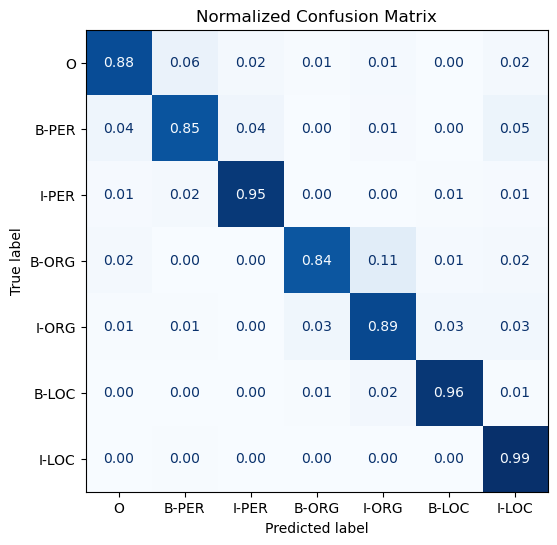

In [158]:
ner.plot.plot_confusion_matrix(df_tokens.labels, df_tokens.predicted_labels, tags.names)

## Evaluate Cross Lingual Performance
* evaluating performance on other languages without re-training.

In [36]:
def get_f1_score(trainer: tfm.Trainer, dataset: datasets.Dataset) -> float:
    return trainer.predict(dataset).metrics["test_f1"]


f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"f1-scores of [de]-trained model on [de] test dataset is: {f1_scores['de']['de']:.3f}")

100%|██████████| 263/263 [01:16<00:00,  3.46it/s]

f1-scores of [de]-trained model on [de] test dataset is: 0.861


In [37]:
def evaluate_lang_performance(lang: str, trainer: tfm.Trainer) -> float:
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, ds_encoded["test"])

for lang in ["fr", "it", "en"]:
    f1_scores["de"][lang] = evaluate_lang_performance(lang, trainer)
    print(f"f1-score of [de]-trained model on [{lang}] test dataset is: {f1_scores['de'][lang]:.3f}")

100%|██████████| 96/96 [00:22<00:00,  4.18it/s]


f1-score of [de]-trained model on [fr] test dataset is: 0.706


100%|██████████| 35/35 [00:08<00:00,  4.31it/s]


f1-score of [de]-trained model on [it] test dataset is: 0.696


100%|██████████| 25/25 [00:05<00:00,  4.26it/s]

f1-score of [de]-trained model on [en] test dataset is: 0.598


In [38]:
f1_scores

defaultdict(dict,
            {'de': {'de': 0.8608626740631722,
              'fr': 0.7058823529411765,
              'it': 0.6957997454391174,
              'en': 0.5980670835702103}})

### what language specific dataset size is necessary to beat zero-shot transfer on higher resource model?
* example from FR
steps:
* train a model on a dataset of increasing size in French
* evaluate its performance on fr test dataset


In [40]:
def train_on_subset(dataset: datasets.Dataset, num_samples: int) -> pd.DataFrame:
    """train a model on a subset of a total dataset of size `num_samples`. extract f1-scores"""

    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]

    training_args.logging_steps = len(train_ds) // BATCH_SIZE
    trainer = tfm.Trainer(
        model_init=model_init, 
        args=training_args,
        data_collator=data_collator, 
        compute_metrics=seqeval_converter.compute_metrics,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        tokenizer=xlmr_tokenizer,
    )

    trainer.train()

    f1_score = get_f1_score(trainer=trainer, dataset=test_ds)

    return pd.DataFrame({"num_samples": [num_samples], "f1_score": [f1_score]})



In [41]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

subset_df = train_on_subset(panx_fr_encoded, 250)
subset_df

Loading cached processed dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-7f028a01a5fa4a2c.arrow
Loading cached processed dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5eb1e7e2bdc288cf.arrow
Loading cached processed dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-276d0daf34adb6cc.arrow
/Users/spayot/miniforge3/envs/tfm4/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 30%|███       | 10/33 [00:20<00:39,  1.73s/it]

{'loss': 1.6557, 'learning_rate': 1.3939393939393942e-05, 'epoch': 0.91}


                                               
 33%|███▎      | 11/33 [00:44<00:35,  1.61s/it]

{'eval_loss': 1.4775304794311523, 'eval_f1': 0.0, 'eval_runtime': 22.6371, 'eval_samples_per_second': 101.161, 'eval_steps_per_second': 4.241, 'epoch': 1.0}


 61%|██████    | 20/33 [01:01<00:29,  2.25s/it]

{'loss': 1.412, 'learning_rate': 7.87878787878788e-06, 'epoch': 1.82}


                                               
 67%|██████▋   | 22/33 [01:26<00:19,  1.80s/it]

{'eval_loss': 1.3657972812652588, 'eval_f1': 0.0, 'eval_runtime': 22.2322, 'eval_samples_per_second': 103.004, 'eval_steps_per_second': 4.318, 'epoch': 2.0}


 91%|█████████ | 30/33 [01:43<00:07,  2.42s/it]

{'loss': 1.315, 'learning_rate': 1.8181818181818183e-06, 'epoch': 2.73}


                                               
100%|██████████| 33/33 [02:09<00:00,  3.92s/it]


{'eval_loss': 1.3307245969772339, 'eval_f1': 0.0, 'eval_runtime': 21.9764, 'eval_samples_per_second': 104.203, 'eval_steps_per_second': 4.368, 'epoch': 3.0}
{'train_runtime': 129.4619, 'train_samples_per_second': 5.793, 'train_steps_per_second': 0.255, 'train_loss': 1.4574045412468188, 'epoch': 3.0}


100%|██████████| 96/96 [00:23<00:00,  4.01it/s]


,num_samples,f1_score
0,250,0.0


In [42]:
for num_samples in [500, 1000, 2000]:
    subset_df = subset_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

Loading cached shuffled indices for dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-2311d41ec9a03774.arrow
/Users/spayot/miniforge3/envs/tfm4/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 32%|███▏      | 20/63 [00:48<01:35,  2.21s/it]

{'loss': 1.5147, 'learning_rate': 1.3650793650793652e-05, 'epoch': 0.95}


 33%|███▎      | 21/63 [01:13<01:21,  1.94s/it]

{'eval_loss': 1.298267126083374, 'eval_f1': 0.03580016029922522, 'eval_runtime': 23.3182, 'eval_samples_per_second': 98.207, 'eval_steps_per_second': 4.117, 'epoch': 1.0}


 63%|██████▎   | 40/63 [02:00<00:56,  2.46s/it]

{'loss': 1.1545, 'learning_rate': 7.301587301587301e-06, 'epoch': 1.9}


 67%|██████▋   | 42/63 [02:29<00:57,  2.75s/it]

{'eval_loss': 1.0415717363357544, 'eval_f1': 0.23568136932192235, 'eval_runtime': 23.1456, 'eval_samples_per_second': 98.939, 'eval_steps_per_second': 4.148, 'epoch': 2.0}


 95%|█████████▌| 60/63 [03:16<00:08,  2.71s/it]

{'loss': 0.9972, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


100%|██████████| 63/63 [03:45<00:00,  3.58s/it]


{'eval_loss': 0.9526299834251404, 'eval_f1': 0.29579461332493306, 'eval_runtime': 21.6612, 'eval_samples_per_second': 105.719, 'eval_steps_per_second': 4.432, 'epoch': 3.0}
{'train_runtime': 225.2873, 'train_samples_per_second': 6.658, 'train_steps_per_second': 0.28, 'train_loss': 1.2097306175837441, 'epoch': 3.0}


100%|██████████| 96/96 [00:22<00:00,  4.22it/s]
/var/folders/ds/s6rqbzwj33q811h82fdmj_6w0000gn/T/ipykernel_64636/3174895469.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  subset_df = subset_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)
Loading cached shuffled indices for dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-2311d41ec9a03774.arrow
 33%|███▎      | 41/126 [01:17<02:45,  1.95s/it]

{'loss': 1.3695, 'learning_rate': 1.3492063492063494e-05, 'epoch': 0.98}


                                                
 33%|███▎      | 42/126 [01:40<02:33,  1.83s/it]

{'eval_loss': 0.990759015083313, 'eval_f1': 0.25126903553299496, 'eval_runtime': 21.7031, 'eval_samples_per_second': 105.515, 'eval_steps_per_second': 4.423, 'epoch': 1.0}


 65%|██████▌   | 82/126 [03:01<01:13,  1.66s/it]

{'loss': 0.8003, 'learning_rate': 6.984126984126984e-06, 'epoch': 1.95}


                                                
 67%|██████▋   | 84/126 [03:28<01:11,  1.69s/it]

{'eval_loss': 0.6109403967857361, 'eval_f1': 0.6145026340254106, 'eval_runtime': 22.8186, 'eval_samples_per_second': 100.357, 'eval_steps_per_second': 4.207, 'epoch': 2.0}


 98%|█████████▊| 123/126 [04:36<00:05,  1.78s/it]

{'loss': 0.572, 'learning_rate': 4.7619047619047623e-07, 'epoch': 2.93}


                                                 
100%|██████████| 126/126 [05:03<00:00,  2.41s/it]


{'eval_loss': 0.5201591849327087, 'eval_f1': 0.6796675191815859, 'eval_runtime': 21.8849, 'eval_samples_per_second': 104.638, 'eval_steps_per_second': 4.387, 'epoch': 3.0}
{'train_runtime': 303.4153, 'train_samples_per_second': 9.887, 'train_steps_per_second': 0.415, 'train_loss': 0.9047734264343504, 'epoch': 3.0}


100%|██████████| 96/96 [00:23<00:00,  4.10it/s]
Loading cached shuffled indices for dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-2311d41ec9a03774.arrow
 33%|███▎      | 83/252 [02:40<05:24,  1.92s/it]

{'loss': 0.995, 'learning_rate': 1.3412698412698413e-05, 'epoch': 0.99}


                                                
 33%|███▎      | 84/252 [03:03<04:36,  1.65s/it]

{'eval_loss': 0.5013786554336548, 'eval_f1': 0.6818181818181818, 'eval_runtime': 22.1812, 'eval_samples_per_second': 103.241, 'eval_steps_per_second': 4.328, 'epoch': 1.0}


 66%|██████▌   | 166/252 [05:44<03:04,  2.14s/it]

{'loss': 0.4332, 'learning_rate': 6.825396825396826e-06, 'epoch': 1.98}


                                                 
 67%|██████▋   | 168/252 [06:09<02:30,  1.80s/it]

{'eval_loss': 0.39649808406829834, 'eval_f1': 0.752628120893561, 'eval_runtime': 21.8417, 'eval_samples_per_second': 104.845, 'eval_steps_per_second': 4.395, 'epoch': 2.0}


 99%|█████████▉| 249/252 [08:46<00:06,  2.14s/it]

{'loss': 0.3375, 'learning_rate': 2.3809523809523811e-07, 'epoch': 2.96}


                                                 
100%|██████████| 252/252 [09:13<00:00,  2.20s/it]


{'eval_loss': 0.3630988895893097, 'eval_f1': 0.7809903622465937, 'eval_runtime': 21.7437, 'eval_samples_per_second': 105.318, 'eval_steps_per_second': 4.415, 'epoch': 3.0}
{'train_runtime': 553.2204, 'train_samples_per_second': 10.846, 'train_steps_per_second': 0.456, 'train_loss': 0.5875913065577311, 'epoch': 3.0}


100%|██████████| 96/96 [00:23<00:00,  4.02it/s]


In [43]:
subset_df

,num_samples,f1_score
0,250,0.000000
1,500,0.282576
2,1000,0.690998
3,2000,0.776162


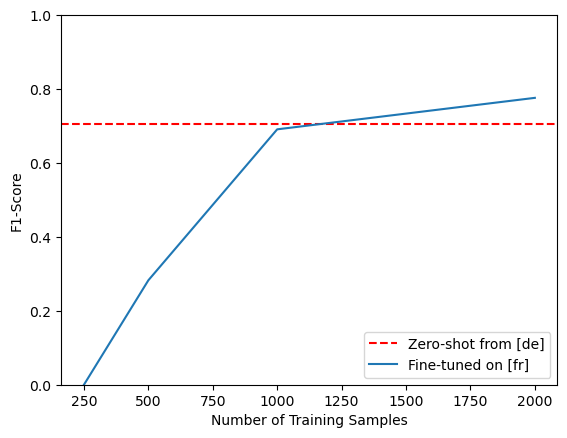

In [45]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
subset_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from [de]", "Fine-tuned on [fr]"], loc="lower right")
plt.ylim((0,1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1-Score")
plt.savefig("../images/zero-shot-from-de-vs-finetuned-fr.jpg")
plt.show()



**Conclusions**: it takes about 1,500 labeled examples in French for it to outperform the model trained on German-only data (12k examples) for the French test set.

## Training on all languages at once
### Encode and Concatenate datasets for each language

In [46]:
def concatenate_splits(corpora: list[datasets.DatasetDict]) -> datasets.DatasetDict:
    multi_corpus = datasets.DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = datasets.concatenate_datasets(
            [corpus[split] for corpus in corpora]
            ).shuffle(seed=42)
    return multi_corpus


langs = ["de", "fr", "it", "en"]

# initialize corpora
corpora = [encode_panx_dataset(panx_ch[lang]) for lang in langs]

corpora_encoded = concatenate_splits(corpora)

100%|██████████| 13/13 [00:00<00:00, 20.66ba/s]
Loading cached processed dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5aff204934de6ebd.arrow
Loading cached processed dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-9d8b48dc6bfa4672.arrow
Loading cached processed dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-7f028a01a5fa4a2c.arrow
Loading cached processed dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5eb1e7e2bdc288cf.arrow
Loading cached processed dataset at /Users/spayot/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-276d0

In [50]:
for split in corpora_encoded:
    print(f"{split:<20} {len(corpora_encoded[split])}")

train                20020
validation           10010
test                 10010


In [51]:
training_args.logging_steps = len(corpora_encoded["train"]) // BATCH_SIZE
training_args.output_dir = "../models/xlm-roberta-base-finetuned-panx-all-ch"

xtrainer = tfm.Trainer(
    model_init=model_init, 
    args=training_args,
    data_collator=data_collator, 
    compute_metrics=seqeval_converter.compute_metrics,
    train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"],
    tokenizer=xlmr_tokenizer,
)

xtrainer.train()

for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(xtrainer, corpora[idx]["test"])

print(f1_scores)

/Users/spayot/miniforge3/envs/tfm4/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 834/2505 [29:46<41:30,  1.49s/it]  

{'loss': 0.3207, 'learning_rate': 1.3341317365269462e-05, 'epoch': 1.0}


                                                  
 33%|███▎      | 835/2505 [31:50<34:11,  1.23s/it]

{'eval_loss': 0.19176006317138672, 'eval_f1': 0.8163530175210902, 'eval_runtime': 124.056, 'eval_samples_per_second': 80.689, 'eval_steps_per_second': 3.369, 'epoch': 1.0}


 67%|██████▋   | 1668/2505 [54:20<20:39,  1.48s/it]  

{'loss': 0.173, 'learning_rate': 6.682634730538923e-06, 'epoch': 2.0}


 67%|██████▋   | 1670/2505 [56:22<15:50,  1.14s/it]

{'eval_loss': 0.17086975276470184, 'eval_f1': 0.8427691087967135, 'eval_runtime': 120.2927, 'eval_samples_per_second': 83.214, 'eval_steps_per_second': 3.475, 'epoch': 2.0}


100%|█████████▉| 2502/2505 [1:16:29<00:03,  1.33s/it]

{'loss': 0.1324, 'learning_rate': 2.3952095808383236e-08, 'epoch': 3.0}


                                                     
100%|██████████| 2505/2505 [1:18:31<00:00,  1.88s/it]


{'eval_loss': 0.17233458161354065, 'eval_f1': 0.8488871252840806, 'eval_runtime': 118.0063, 'eval_samples_per_second': 84.826, 'eval_steps_per_second': 3.542, 'epoch': 3.0}
{'train_runtime': 4711.4629, 'train_samples_per_second': 12.748, 'train_steps_per_second': 0.532, 'train_loss': 0.20856272060714082, 'epoch': 3.0}


100%|██████████| 25/25 [00:06<00:00,  3.92it/s]

defaultdict(<class 'dict'>, {'de': {'de': 0.8608626740631722, 'fr': 0.7058823529411765, 'it': 0.6957997454391174, 'en': 0.5980670835702103}, 'all': {'de': 0.8596302787042795, 'fr': 0.8529411764705883, 'it': 0.8670469504168495, 'en': 0.7558962264150942}})


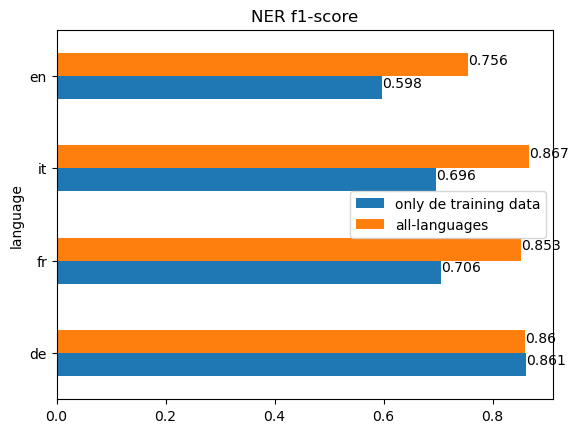

In [74]:
SCORE_IMAGE_PATH = "../images/f1_scores.jpg"

ner.plot.plot_f1_scores(f1_scores, save_path=SCORE_IMAGE_PATH)

## Save Model

In [52]:
# saves in args.output_dir directory
xtrainer.save_model()

## inspect model

In [83]:
text = "Je connais un certain Sylvain Payot qui est data scientist et travaille en Bretagne pour Nike"
ner.inspect.tag_text(text, xtrainer.model, xlmr_tokenizer, tags)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
tokens,<s>,▁Je,▁connais,▁un,▁certain,▁Sylv,ain,▁Pay,ot,▁qui,...,▁data,▁scientist,▁et,▁travaille,▁en,▁,Bretagne,▁pour,▁Nike,</s>
tags,O,O,O,O,O,B-PER,I-PER,I-PER,I-PER,O,...,B-ORG,O,O,O,O,B-LOC,B-LOC,O,B-ORG,O


## Reload a model

In [84]:
text = "Je connais un certain Sylvain Payot qui est data scientist et travaille dans l'Oregon pour Nike"
ner_pipeline = tfm.pipeline("ner", model=training_args.output_dir)
pd.DataFrame(ner_pipeline(text))



,entity,score,index,word,start,end
0,B-PER,0.994795,5,▁Sylv,22,26
1,I-PER,0.625905,6,ain,26,29
2,I-PER,0.997478,7,▁Pay,30,33
3,I-PER,0.995401,8,ot,33,35
4,B-ORG,0.976891,22,▁Nike,91,95
